## Sberbank Russian Housing Market  -  House price prediction

In [1]:
# importing libraries

import os
os.chdir('C:/Users/manum/Desktop/Daily Study/Kaggle_Competitions/2.Sberbank Russian Housing Market - House Price Prediction/Data')
print('Working Directory :','\n',os.getcwd(),'\n')

import numpy as np # linear algebra
import pandas as pd # data processing and manipulation( import csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection, preprocessing
import xgboost as xgb

color=sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None # default=warn

Working Directory : 
 C:\Users\manum\Desktop\Daily Study\Kaggle_Competitions\2.Sberbank Russian Housing Market - House Price Prediction\Data 



In [2]:
# importing the training data, csv file

train_df = pd.read_csv('train.csv')
train_df.shape

#train_df['timestamp']=pd.to_datetime(train_df.timestamp)

(30471, 292)

In [3]:
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


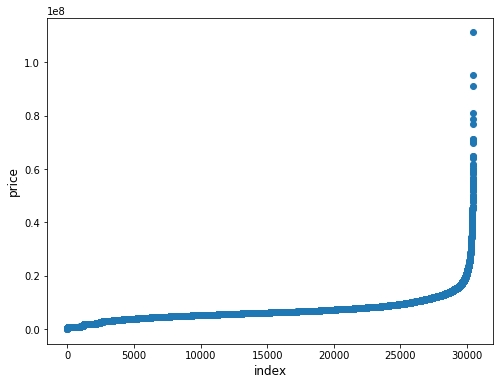

In [4]:
# let's explore the target variable 'price_doc'

plt.figure(figsize=(8,6))

plt.scatter(range(train_df.shape[0]),np.sort(train_df.price_doc.values))

plt.xlabel('index',fontsize=12)
plt.ylabel('price',fontsize=12)

plt.show()


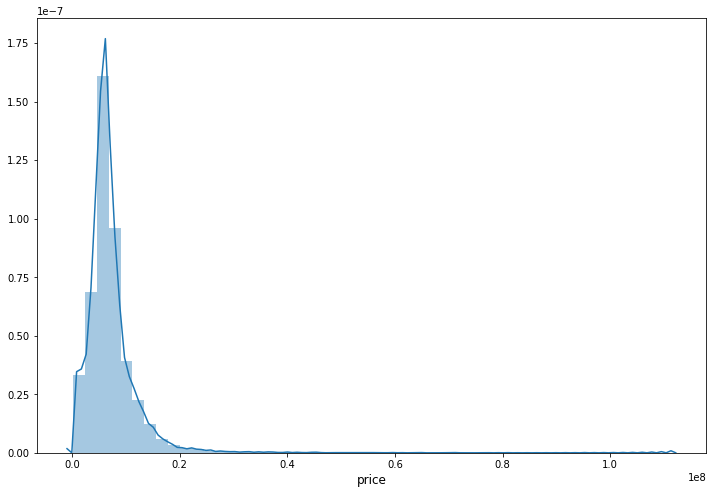

In [5]:
#let's now bin the 'price_doc' to see the distribution

plt.figure(figsize=(12,8))
sns.distplot(train_df.price_doc.values, bins=50, kde=True)

plt.xlabel('price', fontsize=12)
plt.show()

* Price Distribution has a really long tail. Since we are considering Root Mean Square Logarirhmic error(RMSLE), let''s plot the log of the price_doc

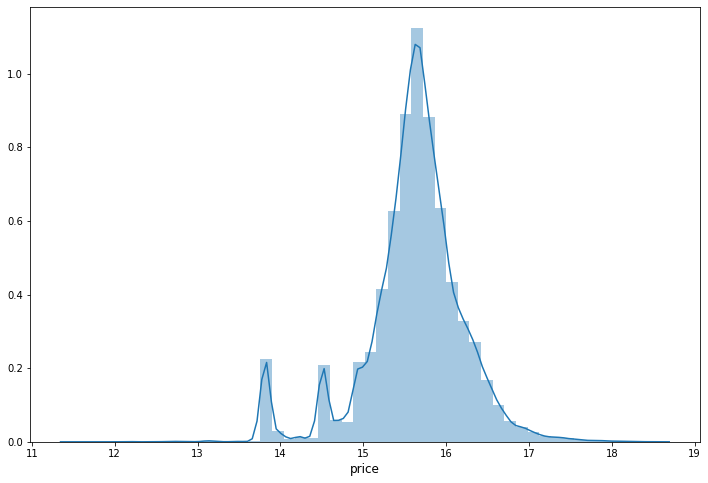

In [6]:
plt.figure(figsize=(12,8))

sns.distplot(np.log(train_df.price_doc.values),bins=50, kde=True)

plt.xlabel('price',fontsize=12)

plt.show()

* This looks pretty much normal compared to the previous non-log distribution

### Median house price change with time

In [17]:
#train_df['yearmonth']=train_df['timestamp'].apply(lambda x: x[:4]+x[5:7])

grouped_df=train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

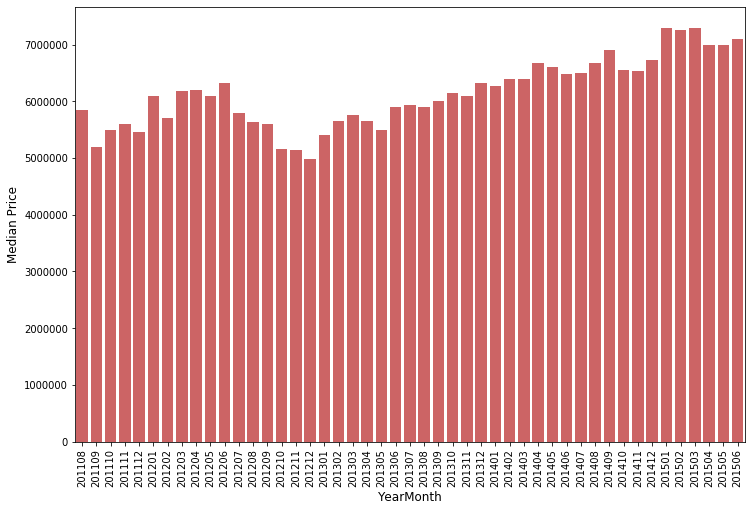

In [29]:
plt.figure(figsize=(12,8))
sns.barplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8, color=color[3])

plt.ylabel('Median Price', fontsize=12)
plt.xlabel('YearMonth', fontsize=12)

plt.xticks(rotation='vertical')

plt.show()

* There are some variations in the median price with respect to time. Towards the end, there seems to be some linear increase in the price values.

In [42]:
###### let's examine the predictor variables now. First let's get the count of variables by their data types

train_df = pd.read_csv("train.csv", parse_dates=['timestamp'])

dtype_df=train_df.dtypes.reset_index()

dtype_df.columns=['Count','Column Type']

dtype_df.groupby('Column Type')['Count'].aggregate('count').reset_index()

,Column Type,Count
0,int64,157
1,datetime64[ns],1
2,float64,119
3,object,15


* Majority of them are numerical variables with 15 factor variables and 1 date variable.

### Let's explore the missing values in the varaibles

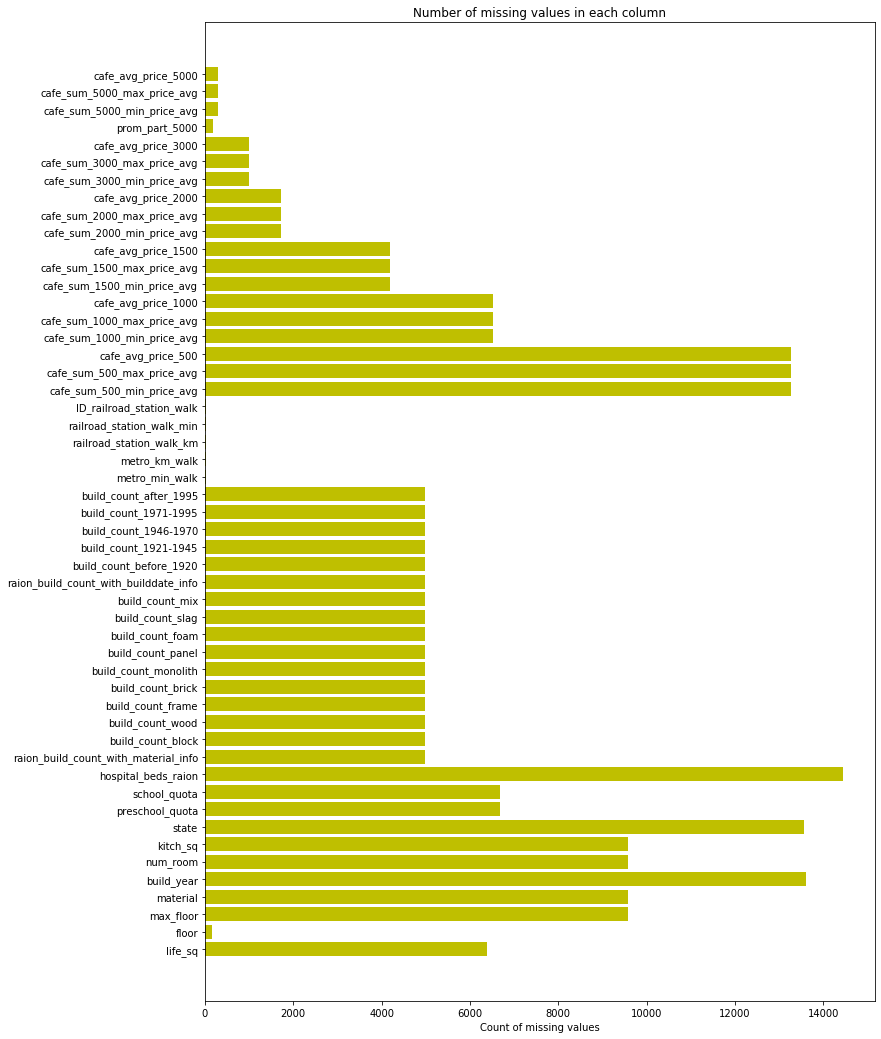

In [53]:
missing_df=train_df.isnull().sum(axis=0).reset_index()

missing_df.columns=['column_name','missing_count']

missing_df=missing_df[missing_df['missing_count']>0]

ind=np.arange(missing_df.shape[0])

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

* Seems variables are found to missing as groups.

## Since there are 292 variables, let us build a basic xgboost model and then explore only the important variables.

[13:49:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:49:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.


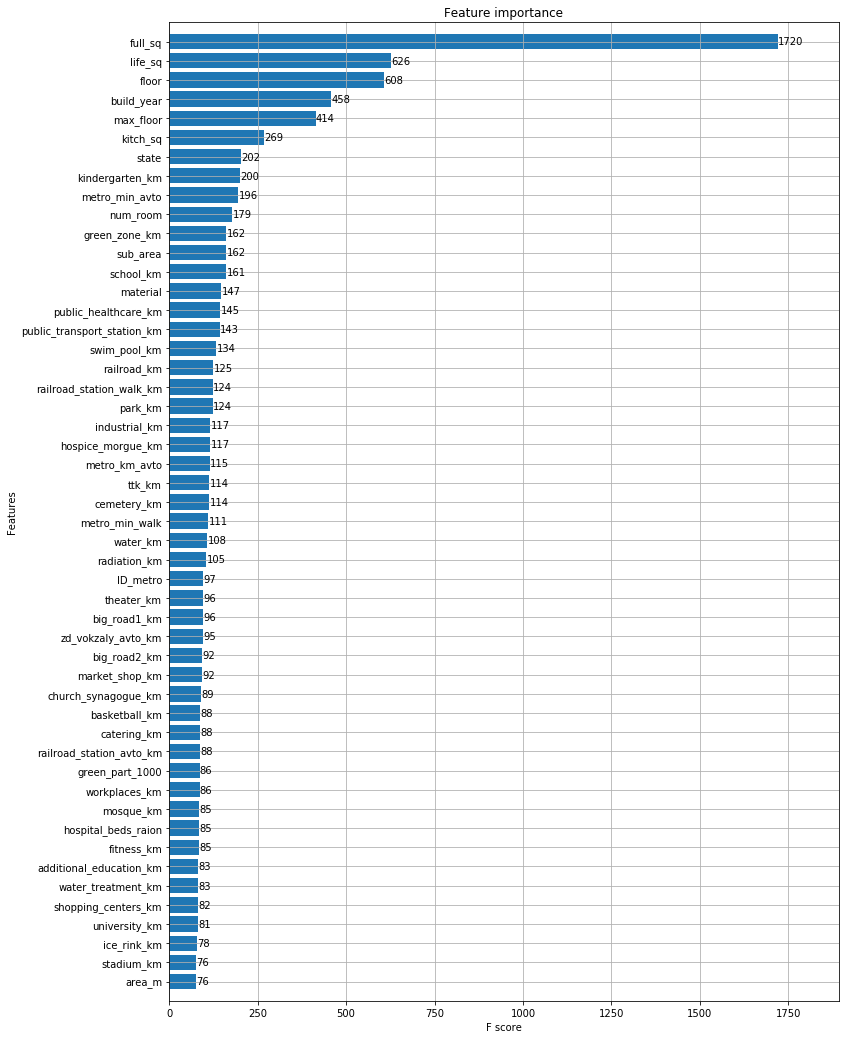

In [60]:
for f in train_df.columns:
    if train_df[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f]=lbl.transform(list(train_df[f].values))
        
train_y=train_df.price_doc.values
train_X=train_df.drop(['id','timestamp','price_doc'],axis=1)


xgb_params={
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}


dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)


# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

        
        

##### So the top 5 variables and their description from the data dictionary are:


* full_sq - total area in square meters, including loggias, balconies and other non-residential areas<br>
* life_sq - living area in square meters, excluding loggias, balconies and other non-residential areas<br>
* floor - for apartments, floor of the building<br>
* max_floor - number of floors in the building<br>
* build_year - year built<br>
* Now let us see how these important variables are distributed with respect to target variable<br>

* Now let us see how these important variables are distributed with respect to target variable.

### Total area in square meters:

C:\Users\manum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\manum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\manum\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-

<Figure size 864x864 with 0 Axes>

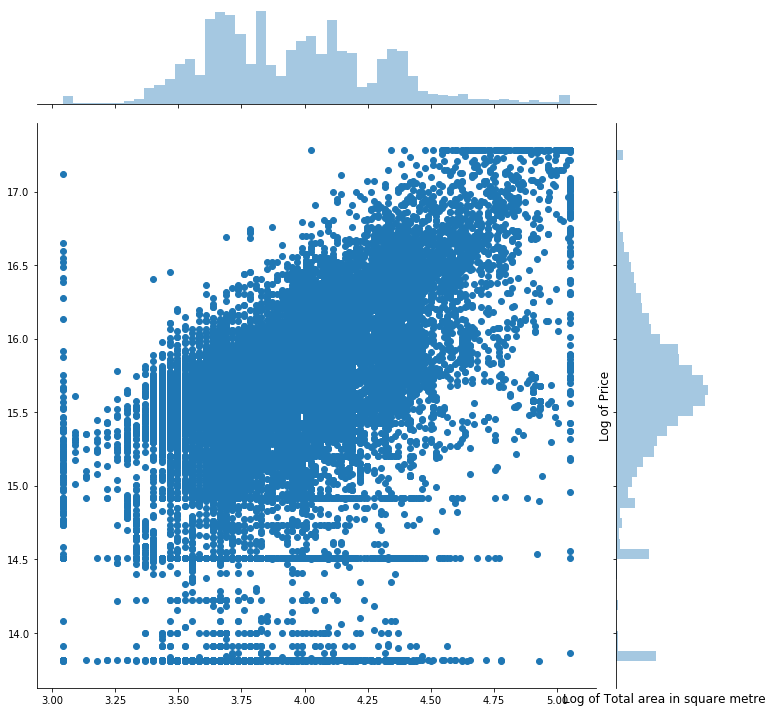

In [61]:
ulimit = np.percentile(train_df.price_doc.values, 99.5)
llimit = np.percentile(train_df.price_doc.values, 0.5)
train_df['price_doc'].ix[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].ix[train_df['price_doc']<llimit] = llimit

col = "full_sq"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.full_sq.values), y=np.log1p(train_df.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square metre', fontsize=12)
plt.show()

### Living area in square meters:

C:\Users\manum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """
C:\Users\manum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


<Figure size 864x864 with 0 Axes>

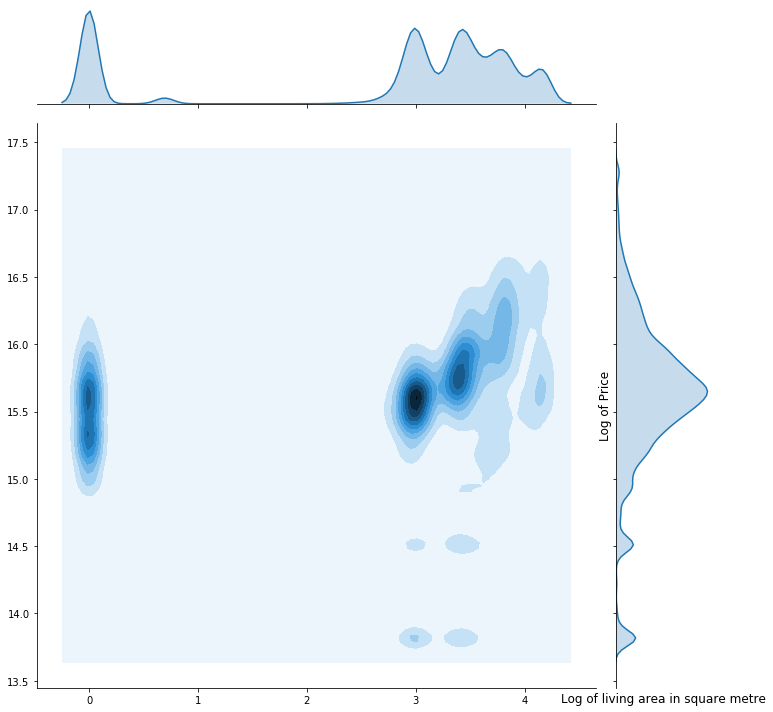

In [62]:
col = "life_sq"
train_df[col].fillna(0, inplace=True)
ulimit = np.percentile(train_df[col].values, 95)
llimit = np.percentile(train_df[col].values, 5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=np.log1p(train_df.life_sq.values), y=np.log1p(train_df.price_doc.values), 
              kind='kde', size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of living area in square metre', fontsize=12)
plt.show()

### Floor:

* We will see the count plot of floor variable.

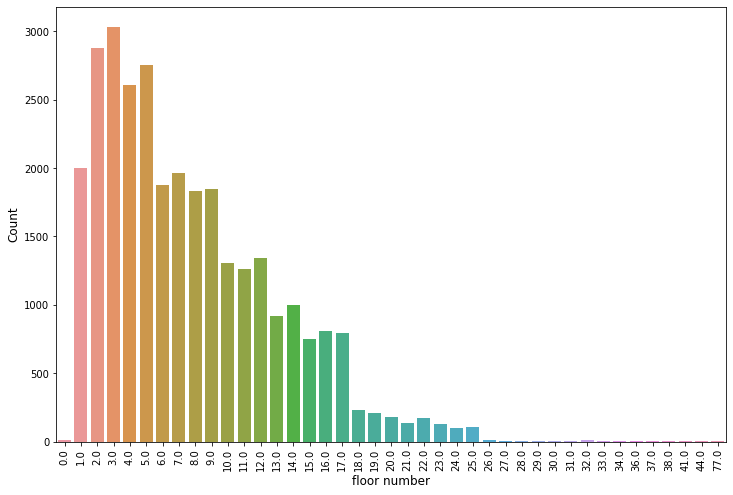

In [63]:
plt.figure(figsize=(12,8))
sns.countplot(x="floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

* The distribution is right skewed. There are some good drops in between (5 to 6, 9 to 10, 12 to 13, 17 to 18). Now let us see how the price changes with respect to floors.

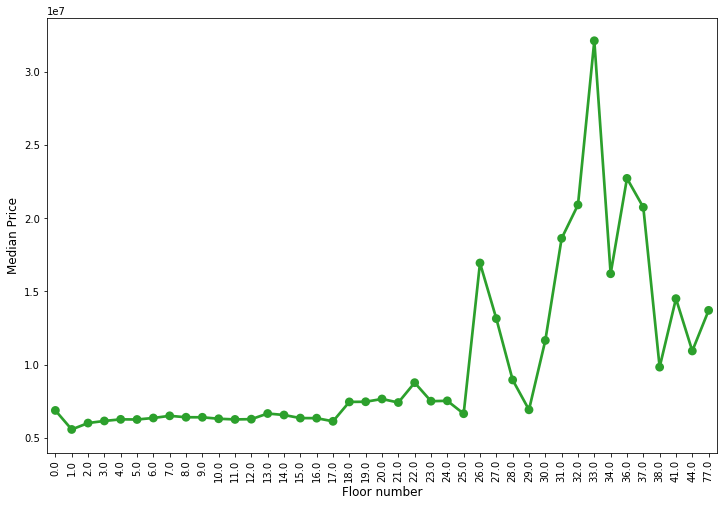

In [64]:
grouped_df = train_df.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df.floor.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

* This shows an overall increasing trend (individual houses seems to be costlier as well - check price of 0 floor houses). A sudden increase in the house price is also observed at floor 18.

## Max floor:

* Total number of floors in the building is one another important variable. So let us plot that one and see.

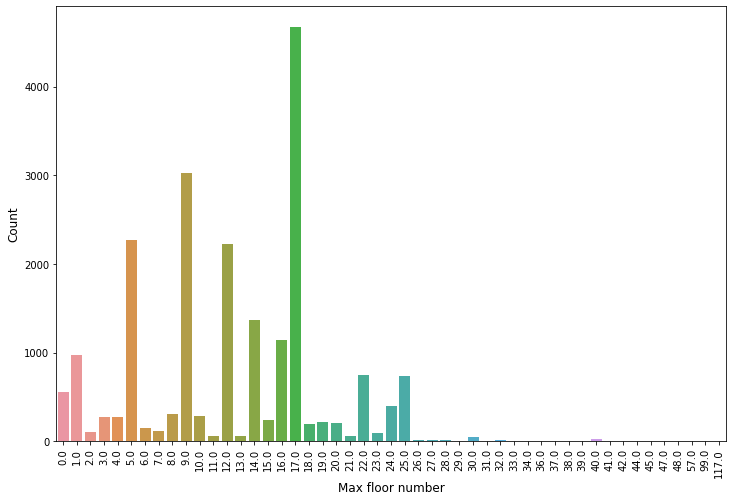

In [66]:
plt.figure(figsize=(12,8))
sns.countplot(x="max_floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Max floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

* We could see that there are few tall bars in between (at 5,9,12,17 - similar to drop in floors in the previous graph). May be there are some norms / restrictions on the number of maximum floors present(?).

* Now let us see how the median prices vary with the max floors.

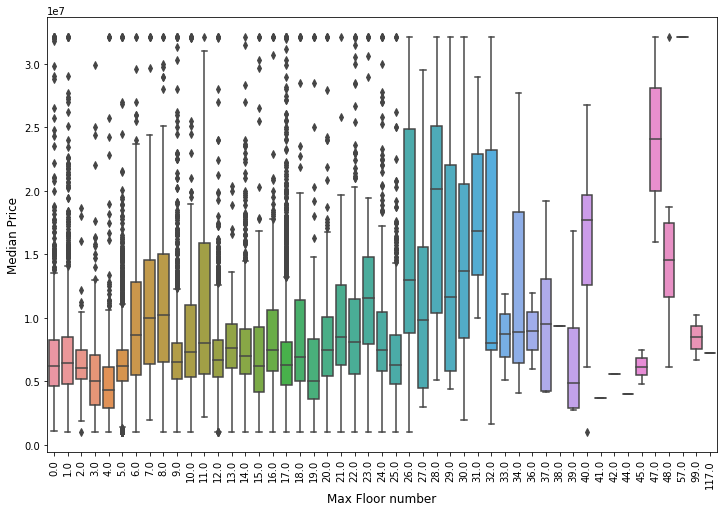

In [67]:
plt.figure(figsize=(12,8))
sns.boxplot(x="max_floor", y="price_doc", data=train_df)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()
